1. Load the model
2. Load the data
3. Perform some visualization
4. Understand the mask and the pattern variables
5. Understand the two critical parts

the gtsrb_dataset_int.h5 spits the following

data['Y_test'].shape:  (12630, 43)

data['X_test'].shape:  (12630, 32, 32, 3)

So **data** is a Dictionary holding a numpy arrays.

#### Possible vulnerabilities:
I have to downgrade tensorflow to version 2.0.0 from 2.2.0. 


#### RUN ONLY IF YOU ARE ON GOOGLE COLAB:

In [1]:
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
PROJECT_PATH_REPO = "/content/drive/My Drive/cingisalexander/trigger_generation"
%cd {PROJECT_PATH_REPO}

/content/drive/My Drive/cingisalexander/trigger_generation


In [3]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 37.4MB/s 
     |████████████████████████████████| 450kB 56.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=f22cbd18dc9f082426c03eae02f449097c007689bd470ca4e4884565778674a8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstall

### Here starts the actual implementation

In [0]:
#Import necessary libraries

import numpy as np
import random

import h5py
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Importing own libaries
# Pattern and Mask definition:
from src.Trigger_layer import Trigger

%matplotlib inline

In [0]:
#### Global Variables
DATA_DIR = "./data"
DATA_FILE = "gtsrb_dataset_int.h5"
MODEL_DIR = "./library"
MODEL_FILE = "gtsrb_bottom_right_white_4_target_33.h5"

BATCH_SIZE = 32

NUM_CLASSES = 43

In [0]:
# Define some util functions to load the data and instantiate a data generator.
# The functions were overtaken from Bolun Wang's library.
def load_dataset(data_file=('{}/{}'.format(DATA_DIR, DATA_FILE))):

  dataset = {}
  with h5py.File(data_file, 'r') as hf:
    for name in hf:
      dataset[name] = np.array(hf.get(name))


  X_test = np.array(dataset['X_test'], dtype='float32')
  Y_test = np.array(dataset['Y_test'], dtype='float32')

  print('X_test shape {}'.format(X_test.shape))
  print('Y_test shape {}'.format(Y_test.shape))

  return X_test, Y_test

def build_data_loader(X, Y):

    datagen = ImageDataGenerator()
    generator = datagen.flow(
        X, Y, batch_size=BATCH_SIZE)

    return generator

In [7]:
X, Y = load_dataset('{}/{}'.format(DATA_DIR, DATA_FILE))

X_test shape (12630, 32, 32, 3)
Y_test shape (12630, 43)


In [42]:
print("Instatiating data_generator")
data_generator = build_data_loader(X,Y)
print("What type is data_generator?: ", type(data_generator))

print("\nLoading the model")
model_path = "{}/{}".format(MODEL_DIR, MODEL_FILE)
model_m = load_model(model_path)
print("What type is the model: ", type(model))

Instatiating data_generator
What type is data_generator?:  <class 'keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator'>

Loading the model
What type is the model:  <class 'tensorflow.python.keras.engine.sequential.Sequential'>


#### Implementation of custom training loop


In [43]:
# Implementation of custom training loop:

trigger = Sequential()
trigger_layer = Trigger(input_shape=(32,32,3))

print(trigger_layer)

trigger.add(trigger_layer)

model_m2 = tf.keras.Sequential([
  trigger,
  model_m
])


input_tensor = K.placeholder(model_m2.input_shape)
y_true_tensor = K.placeholder(model_m2.output_shape)


output_tensor = model_m2(input_tensor)


loss_acc = categorical_accuracy(output_tensor, y_true_tensor)
loss_ce = categorical_crossentropy(output_tensor, y_true_tensor)


#loss_reg = K.sum(K.abs(model_m2.trainable_weights[1]))#model_m2.layers[1].get_weights()[0]
loss = loss_ce# + loss_reg


optimizer = Adam()
updates = optimizer.get_updates(params = [model_m2.trainable_weights[0], model_m2.trainable_weights[1]] , loss = loss)
train = K.function([input_tensor, y_true_tensor], [loss, loss_acc], updates = updates)

(None, 32, 32, 3)


In [47]:
#epochs = 3
epochs = 10000

# the pattern should cause that all samples are classified as y_target
y_target = 33
loss = [] 
acc = []
for epoch in range(epochs):
  Y_target = to_categorical([y_target]*BATCH_SIZE, NUM_CLASSES)
  X_batch, _ = data_generator.next()
  if X_batch.shape[0] != Y_target.shape[0]:
    Y_target = to_categorical([y_target]*X_batch.shape[0], NUM_CLASSES)

  losses, acces = train([X_batch, Y_target])
  acc.append(np.mean(acces))
  loss.append(np.mean(losses))



print("loss: ", np.mean(loss[0]))
#print(model2.trainable_weights[0])
print(np.sum(model_m2.trainable_weights[1].numpy()))
print(np.sum(model_m2.trainable_weights[0].numpy()))

loss:  3.120644
-805.31836
146.01321


<function matplotlib.pyplot.tight_layout>

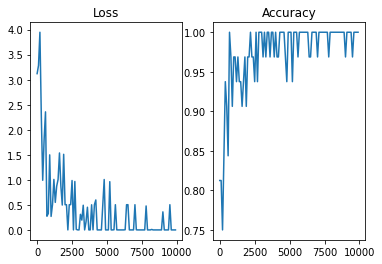

In [79]:
plt.subplot(1,2,1)
plt.plot(range(0,epochs, 100), np.array(loss)[np.arange(0,epochs, 100, dtype = int)])
plt.title ("Loss")

plt.subplot(1,2,2)
plt.plot(range(0,epochs, 100), np.array(acc)[np.arange(0,epochs, 100, dtype = int)])
plt.title("Accuracy")
plt.tight_layout

In [64]:
type(loss)

list

In [49]:
# Now we will compare on a batch of data what are the predictions with and without the trigger 
X_batch, Y_batch = data_generator.next()
class_labs = np.argmax(Y_batch, axis = 1)
print("Class labels of a random batch: ", class_labs)
pred = model_m2(X_batch)
print("Predicted labels with the pattern: ", np.argmax(pred, axis = 1))
pred2 = model_m(X_batch)
print("Predicted labels without the pattern: ", np.argmax(pred2, axis = 1))

Class labels of a random batch:  [12  7  6  2 11 17  9  5  8 26 26 12 11 30 13 23 18 25  1 17 12 17 38  9
 26 18  7 18 34 37  1  2]
Predicted labels with the pattern:  [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33 33 33]
Predicted labels without the pattern:  [12  7  6  2 11 17  9  5  8 26 26 12 11 30 13 23 18 25  1 17 40 17 38  9
 26 18  7 18 34 37  1  2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


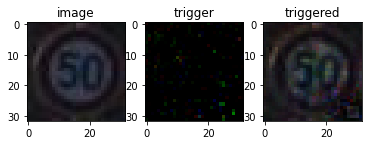

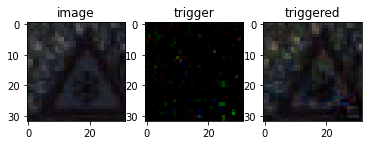

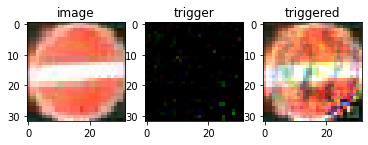

In [91]:
# The second weights are patterns, as we can se in the tf variable description
#print(model2.trainable_weights[1])

for i in [3, 13, 21]:
  plt.figure()
  rand_img = X_batch[i]
  #print(rand_img.shape)
  scaled_rand_img = rand_img/255
  #plt.figure()
  plt.subplot(1,3,1)
  plt.imshow(scaled_rand_img)
  plt.title("image")


  pattern = model_m2.trainable_weights[1].numpy()
  print(pattern.shape)
  #plt.figure()
  plt.subplot(1,3,2)
  plt.imshow(pattern)
  plt.title("trigger")

  mask = model_m2.trainable_weights[0].numpy()
  triggered = rand_img*(K.ones_like(mask)- mask) + pattern*mask
  triggered_scaled = triggered/255
  #plt.figure()
  plt.subplot(1,3,3)
  plt.imshow(triggered_scaled)
  plt.title("triggered")